In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path
from tmm_acc import coh_tmm_normal_spol_spec_d

from HybridNet import *
from NoiseLayer import *

dtype = torch.float
device_data = torch.device('cpu')
device_test = torch.device('cuda:0')


In [2]:
test_data = scio.loadmat(r'D:\zf-py\graduate2\ICVL_400-1000-5\IDS_COLORCHECK_1020-1223.mat')
test_img = test_data['data'][400:800,550:950:]
test_img /= test_img.max()
wl = test_data['wavelength']

RGB_idx = [50,30,10]

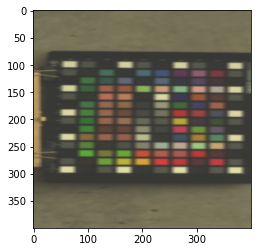

In [3]:
plt.imshow(test_img[:,:,RGB_idx])

In [4]:
cll = ClearNoiseLayer()

test_img_tensor = torch.from_numpy(test_img)
cll_img_tensor = cll(test_img_tensor)
cll_img = cll_img_tensor.numpy()

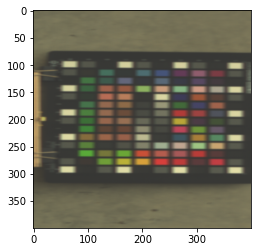

In [5]:
plt.imshow(cll_img[:,:,RGB_idx])

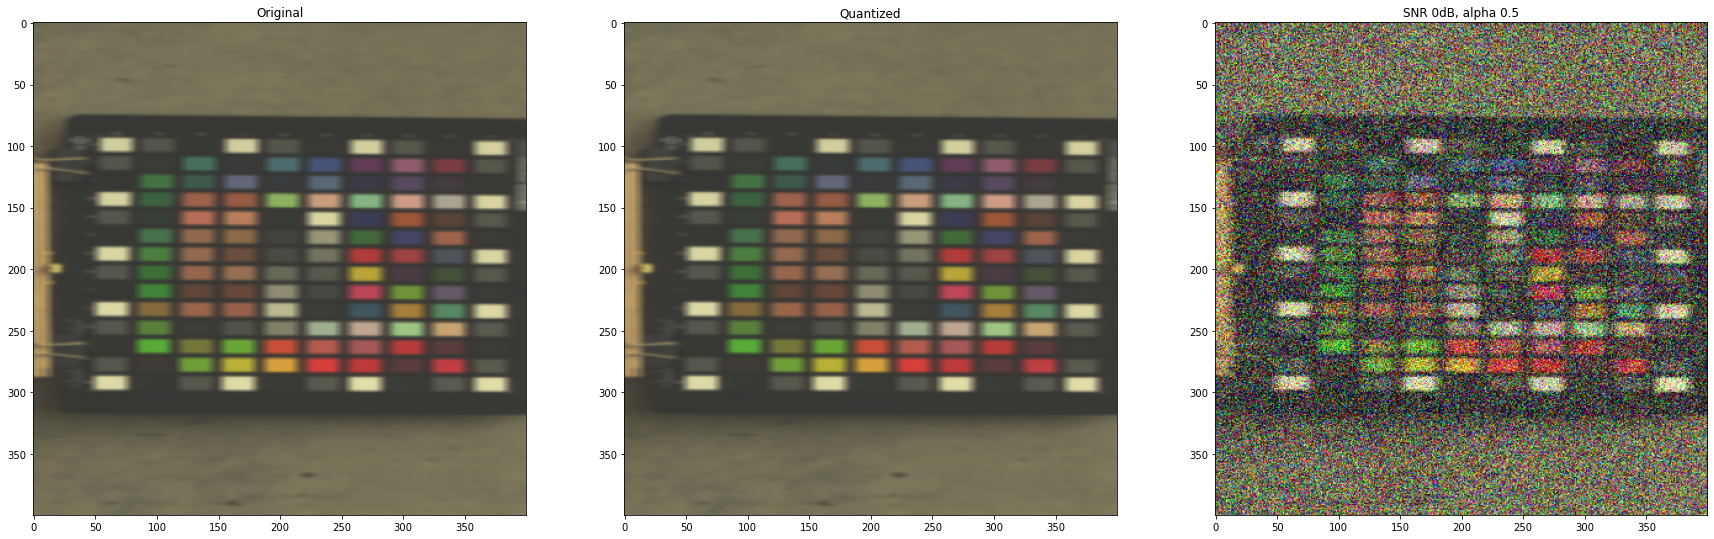

In [32]:
nl = NoiseLayer(0,0.5)

nl_img_tensor = nl(test_img_tensor)
nl_img = nl_img_tensor.numpy()

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(test_img[:,:,RGB_idx])
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(cll_img[:,:,RGB_idx])
plt.title('Quantized')
plt.subplot(1,3,3)
plt.imshow(nl_img[:,:,RGB_idx])
plt.title('SNR 0dB, alpha 0.5')
plt.show()

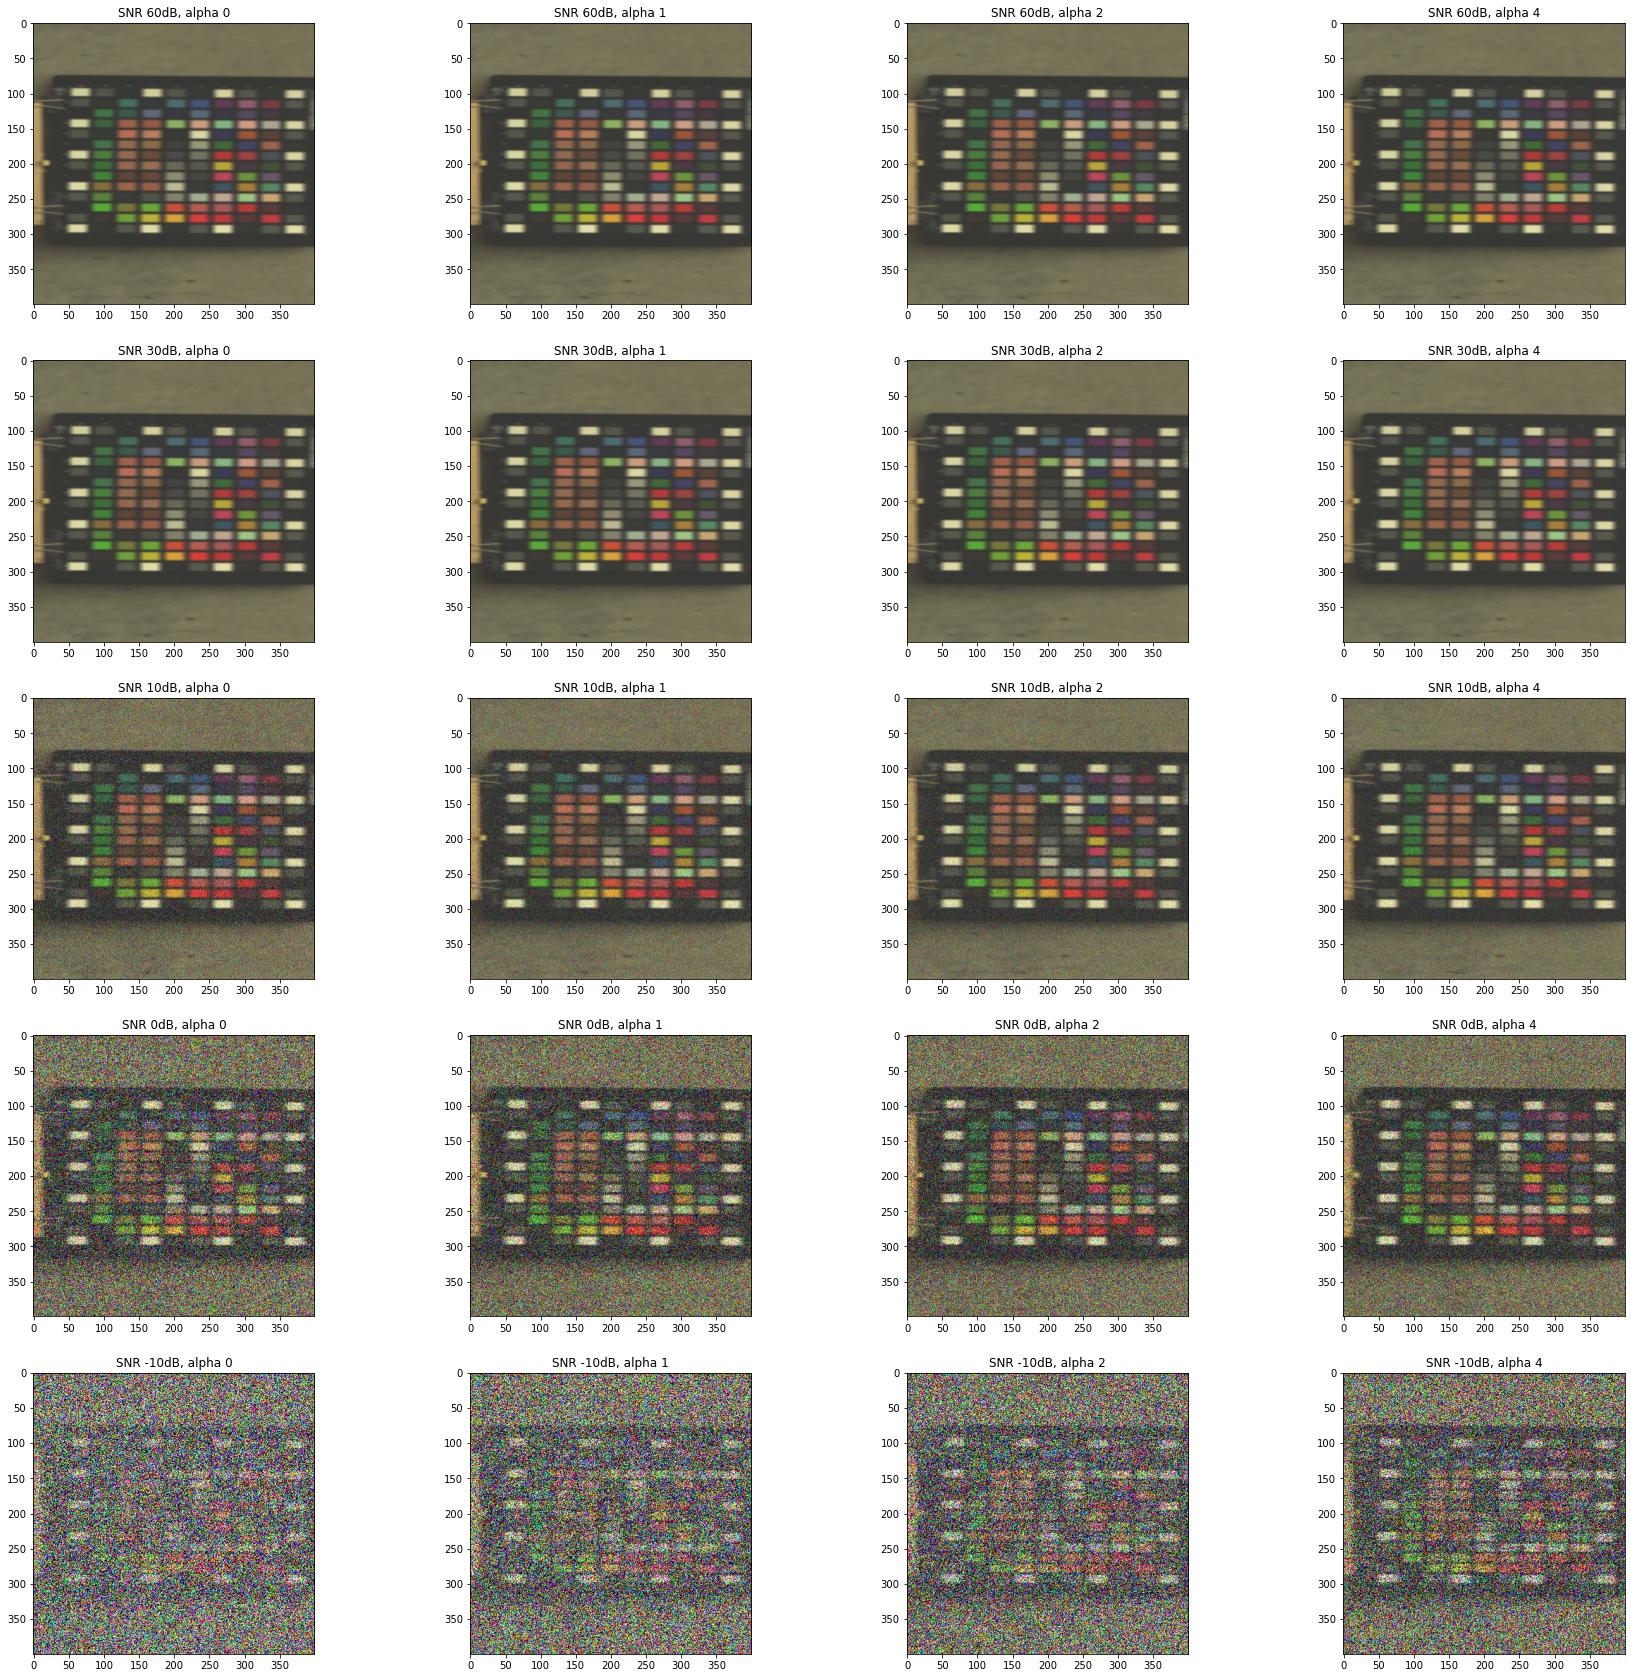

In [33]:
SNR_list = [60, 30,10, 0, -10]
alpha_list = [0, 1, 2, 4]

plt.figure(figsize=(30,30))
for i in range(len(SNR_list)):
    for j in range(len(alpha_list)):
        nl = NoiseLayer(SNR_list[i], alpha_list[j])
        nl_img_tensor = nl(test_img_tensor)
        nl_img = nl_img_tensor.numpy()
        plt.subplot(len(SNR_list),len(alpha_list),i*len(alpha_list)+j+1)
        plt.imshow(nl_img[:,:,RGB_idx])
        plt.title('SNR {}dB, alpha {}'.format(SNR_list[i], alpha_list[j]))
plt.show()

In [51]:
model_folder = Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\20230712_152140')
data = scio.loadmat(r'.\data\ICVL_400-1000-5_100K.mat')
curves = data['data']
TargetCurves_FMN = scio.loadmat(model_folder/'TargetCurves_FMN.mat')['TargetCurves_FMN']
wl = data['wavelength'][0]
nl = NoiseLayer(60,1,8)
noised_curves = nl(torch.from_numpy(curves)).numpy()

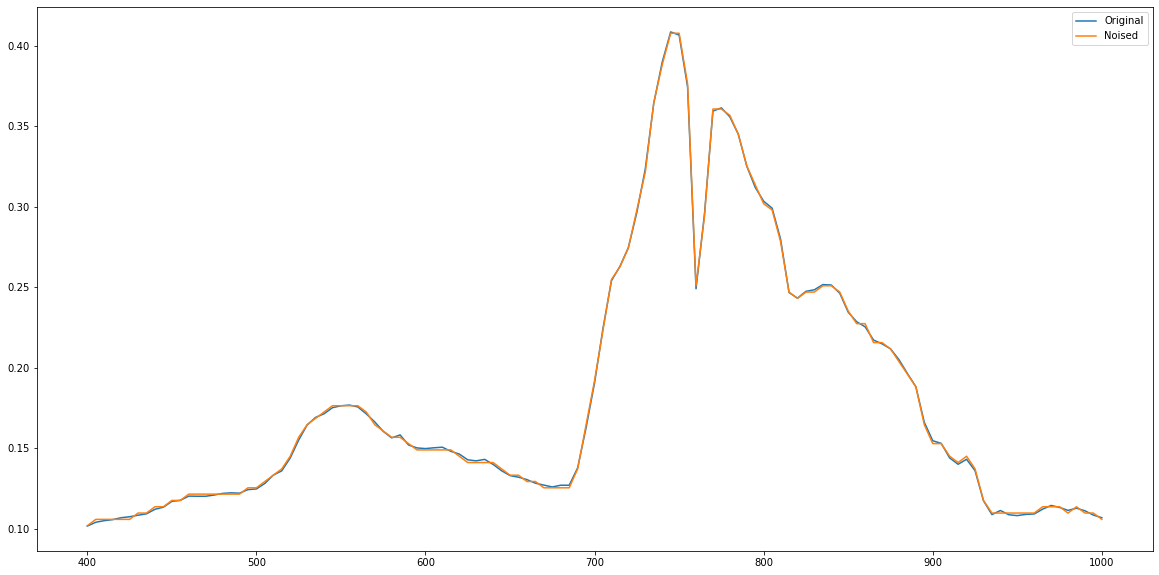

In [47]:
plt.figure(figsize=(20,10))
plt.plot(wl, curves[1], label='Original')
plt.plot(wl, noised_curves[1], label='Noised')
plt.legend()
plt.show()

In [52]:
lossFcn = MatchLossFcn
loss = lossFcn(torch.from_numpy(curves), torch.from_numpy(noised_curves))

In [1]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

In [6]:
calculate_output_length(800,kernel_size=15,padding=7)

800